# Perform one sample test in control cells

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
data_path = '/data_volume/ifn_hbec/'

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [4]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [5]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [6]:
adata.shape

(69958, 36588)

### Setup memento

In [7]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [8]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [9]:
memento.setup_memento(adata, q_column='q')

In [10]:
adata.obs.head(3)

,NUM.SNPS,BEST.GUESS,DROPLET.TYPE,batch,HTO_classification,condition,donor,stim,time,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,cell_type,q,memento_size_factor
AAACCCAAGGAAGTAG-1,1700,donor0,SNG,0,hash-10,d2513_lambda_9,d2513,lambda,9,4297,4297,12191.0,1394.0,11.434665,3,ciliated,0.10425,0.955289
AAACCCAAGGGACTGT-1,839,donor0,SNG,0,hash-3,d2513_alpha_24,d2513,alpha,24,2171,2171,7270.0,386.0,5.309491,5,bc,0.10425,0.824407
AAACCCACAATCTGCA-1,1130,donor1,SNG,0,hash-1,d2614_alpha_3,d2614,alpha,3,3016,3016,9544.0,516.0,5.406538,0,basal,0.10425,0.988939


In [11]:
adata.uns['memento'].keys()

dict_keys(['q_column', 'all_q', 'estimator_type', 'filter_mean_thresh', 'num_bins', 'least_variable_genes', 'all_1d_moments'])

### Compute moments for ciliated cells, beta stim

In [12]:
adata_subset = adata.copy()[
    adata.obs.cell_type.isin(['ciliated']) & \
    adata.obs.stim.isin(['control', 'beta']), :].copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [13]:
memento.create_groups(adata_subset, label_columns=['donor', 'time'])

In [14]:
memento.compute_1d_moments(adata_subset, min_perc_group=.9)

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log


In [15]:
m_df, v_df = memento.get_1d_moments(adata_subset, groupby='time')

In [16]:
m = np.log(adata_subset.uns['memento']['1d_moments']['sg^d2513^9'][0])
v = np.log(adata_subset.uns['memento']['1d_moments']['sg^d2513^9'][1])
rv = np.log(adata_subset.uns['memento']['1d_moments']['sg^d2513^9'][2])

<ipython-input-16-a38f42e99502>:2: RuntimeWarning: invalid value encountered in log
  v = np.log(adata_subset.uns['memento']['1d_moments']['sg^d2513^9'][1])


In [17]:
x = np.linspace(-3, 4, 100)
f = np.poly1d(adata_subset.uns['memento']['mv_regressor']['sg^d2513^9'])
y = f(x)

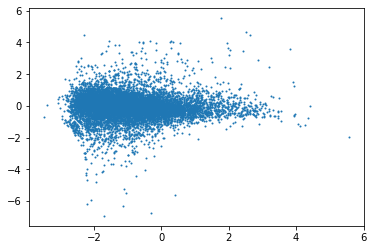

In [18]:
plt.scatter(m, rv, s=1)

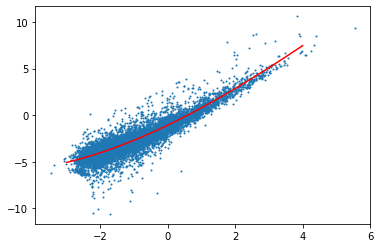

In [19]:
plt.scatter(m,v, s=1)
plt.plot(x,y, color='r')

### Perform one sample test on ciliated, control cells

In [17]:
adata_ctrl = adata.copy()[
    adata.obs.cell_type.isin(['ciliated']) & \
    adata.obs.stim.isin(['control']), :].copy()

In [18]:
memento.create_groups(adata_ctrl, label_columns=['donor'])

In [19]:
memento.compute_1d_moments(adata_ctrl, min_perc_group=.9)

In [20]:
memento.ht_1d_moments(
    adata_ctrl,
    formula_like='1',
    cov_column='Inter',
    num_boot=10000, 
    verbose=1,
    num_cpus=13)

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    2.8s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    6.0s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   11.9s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   19.8s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   29.7s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   41.4s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:   55.7s
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.2min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.5min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]: Done 6024 tasks      | elapsed:  2.3min
[Parallel(n_jobs=13)]: Done 7174 tasks      | elapsed:  2.7min
[Parallel(n_jobs=13)]: Done 8424 tasks      | elapsed:  3.1min
[Parallel(n_jobs=13)]: Done 9774 tasks      | elapsed:  3.6min
[Parallel(n_jobs=13)]: Done 10150 out of 1015

In [21]:
onesamp_ht_df = memento.get_1d_ht_result(adata_ctrl)

In [22]:
m_df.sort_values('time_0', ascending=False)

,gene,time_9,time_3,time_0,time_6,time_48,time_24
5562,MALAT1,5.637802,5.705968,5.511473,5.817672,5.728523,5.680489
5501,FTH1,4.004720,4.003534,4.303639,3.960313,4.109459,4.126245
5616,GSTP1,4.083406,4.013621,4.217525,3.897102,4.180199,4.077558
643,S100A11,4.099605,3.998107,4.204155,4.006808,4.057389,4.108398
6974,B2M,4.348129,4.438093,4.189476,4.546697,4.125379,4.342992
...,...,...,...,...,...,...,...
8820,CEACAM1,-1.101681,-1.749148,-3.194082,-1.242405,-1.167282,-1.065384
9454,TCN2,-1.847112,-2.234941,-3.203103,-1.504837,-1.937603,-1.906946
9519,SYNGR1,-2.577651,-2.665431,-3.259078,-2.275457,-2.424959,-2.448371
8194,AC124319.1,-1.383532,-1.641907,-3.299643,-1.212676,-0.718615,-1.000530


In [23]:
onesamp_ht_df.query('gene == "MX1"')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
9583,MX1,0.523788,0.054562,0.00052,1.763791,0.172606,0.000022


In [24]:
onesamp_ht_df.sort_values('dv_coef', ascending=False).head(20)

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
9347,BPIFA1,1.711823,0.237131,4.969384e-06,4.772759,0.182131,1.827632e-09
5086,MSMB,2.002644,0.232166,3.080184e-05,4.753874,0.312155,2.790933e-07
1640,CCL20,-0.122780,0.209393,5.540446e-01,4.453336,0.180179,7.525264e-07
5618,SCGB1A1,1.821146,0.175603,5.378408e-06,4.449935,0.141542,6.296868e-08
9591,TFF3,1.162709,0.201850,4.005836e-05,4.414665,0.411461,1.494431e-07
9348,BPIFB1,2.132191,0.158443,1.372192e-05,4.029002,0.152292,6.883513e-06
2800,CDC20B,-0.837752,0.208465,1.899810e-03,3.995393,0.102542,2.993558e-06
5416,MUC5B,-0.609397,0.172134,1.844923e-03,3.798337,0.186431,8.733096e-07
6281,TSPAN8,-1.275266,0.221258,7.392769e-06,3.763758,0.445621,1.571243e-07
2802,CCNO,0.747182,0.124553,1.353845e-04,3.682878,0.097091,1.590198e-07


### Mean vs variability plots for ctrl and stim cells

In [ ]:
adata_subset = 

In [17]:
m_df, v_df = memento.get_1d_moments(ctrl_adata, groupby='Inter')

KeyError: 'Inter'

In [16]:
m_df

NameError: name 'm_df' is not defined

### Run memento for each subset, comparing to control

In [17]:
cts = [['ciliated']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [18]:
import os
done_files = os.listdir('/data_volume/ifn_hbec/binary_test_deep/')

In [ ]:
for ct in cts:
    for tp in tps:
        for stim in stims:
            
            fname = '{}_{}_{}_20200313.h5ad'.format('-'.join(ct), stim, tp)
            
            if fname in done_files:
                print('Skipping', fname)
                continue

            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)

            memento.ht_1d_moments(
                adata_stim, 
                formula_like='1 + time_step',
                cov_column='time_step', 
                num_boot=10000, 
                verbose=1,
                num_cpus=13)

            del adata_stim.uns['memento']['mv_regressor']

            adata_stim.write('/data_volume/ifn_hbec/binary_test_deep/{}_{}_{}_20200313.h5ad'.format(
                '-'.join(ct), stim, tp))

starting ['ciliated'] 3 alpha


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    3.1s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    7.2s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   14.6s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   24.5s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   36.6s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   51.4s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.5min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.3min
[Parallel(n_jo

starting ['ciliated'] 3 beta


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.8s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   12.1s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   22.0s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   34.1s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   49.0s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.8min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.3min
[Parallel(n_jo

starting ['ciliated'] 3 gamma


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.7s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   11.7s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   21.4s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   33.3s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   47.7s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.8min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.2min
[Parallel(n_jo

starting ['ciliated'] 3 lambda


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.8s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   12.1s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   22.0s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   34.1s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   49.1s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.8min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.3min
[Parallel(n_jo

starting ['ciliated'] 6 alpha


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.8s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.5s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   11.2s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   20.3s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   31.4s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   45.1s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.0min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.3min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.7min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.1min
[Parallel(n_jo

starting ['ciliated'] 6 beta


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    1.0s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    5.1s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   12.8s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   23.2s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   35.9s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   51.6s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.2min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.5min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.4min
